In [46]:
## imports and data uploads

In [47]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pickle
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter('ignore')
import os
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from scipy.spatial.distance import squareform
from sklearn.metrics import accuracy_score
from matplotlib.gridspec import GridSpec
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [48]:
# upload data
cpath = os.getcwd() #assumes mean_df_females is in the same path as the notebook
female_mean_df = pd.read_csv(cpath+'/mean_df_female.csv')
female_scalar_df = pd.read_csv(cpath+'/scalar_df_female.csv')
female_mean_df.syllable[female_mean_df.syllable==48]=49 #to match syllable id in scalar df
male_mean_df = pd.read_csv(cpath+'/mean_df_male.csv')
male_scalar_df = pd.read_csv(cpath+'/scalar_df_male.csv')

# ----------------------------------------------------------------------- 
# ANALYSIS
# -----------------------------------------------------------------------

In [49]:
# plot/colors definitions
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

plt.style.use("seaborn-paper")

In [50]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='copper', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred,name):
    '''
    plot confusion matrix

    Args:
        y_true ([np.array]): array for true label
        y_pred ([np.array]): array for predicted label
        y_shuffle_true ([np.array]): array for shffuled label
        y_shuffle_pred ([np.array]): array for shuffled predicted label
    '''
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    fig.savefig(data_loc +name+'.pdf', bbox_inches='tight')

In [51]:
def KLD_analysis(frequencies):
    '''rows are sessions (or mice/phases), columns are variables (syllables)'''
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            i[i==0]=.0000000001
            j[j==0]=.0000000001
            cohort_dist[x,y]=scipy.stats.entropy(pk=np.array(i), qk=np.array(j))
            y=y+1
        y=0
        x=x+1
    return cohort_dist

In [52]:
def cal_scalars_sessions(mean_df,scalar_df,metric='robust'):
    # area, height, width, length
    if metric=='robust':
        hdf = scalar_df.groupby(['mouse','rep'])['height_ave_mm'].quantile(0.95) - scalar_df.groupby('mouse')['height_ave_mm'].quantile(0.05)
        wdf = scalar_df.groupby(['mouse','rep'])['width_mm'].quantile(0.95) - scalar_df.groupby('mouse')['width_mm'].quantile(0.05)
        adf = scalar_df.groupby(['mouse','rep'])['area_mm'].quantile(0.95) - scalar_df.groupby('mouse')['area_mm'].quantile(0.05)
        ldf = scalar_df.groupby(['mouse','rep'])['length_mm'].quantile(0.95) - scalar_df.groupby('mouse')['length_mm'].quantile(0.05)
    
    if metric=='range':
        hdf = scalar_df.groupby(['mouse','rep'])['height_ave_mm'].max() - scalar_df.groupby('mouse')['height_ave_mm'].min()
        wdf = scalar_df.groupby(['mouse','rep'])['width_mm'].max() - scalar_df.groupby('mouse')['width_mm'].min()
        adf = scalar_df.groupby(['mouse','rep'])['area_mm'].max() - scalar_df.groupby('mouse')['area_mm'].min()
        ldf = scalar_df.groupby(['mouse','rep'])['length_mm'].max() - scalar_df.groupby('mouse')['length_mm'].min()
    
    if metric=='max':
        hdf = scalar_df.groupby(['mouse','rep'])['height_ave_mm'].max()
        wdf = scalar_df.groupby(['mouse','rep'])['width_mm'].max()
        adf = scalar_df.groupby(['mouse','rep'])['area_mm'].max()
        ldf = scalar_df.groupby(['mouse','rep'])['length_mm'].max()
    
    if metric=='min':
        hdf = scalar_df.groupby(['mouse','rep'])['height_ave_mm'].min()
        wdf = scalar_df.groupby(['mouse','rep'])['width_mm'].min()
        adf = scalar_df.groupby(['mouse','rep'])['area_mm'].min()
        ldf = scalar_df.groupby(['mouse','rep'])['length_mm'].min()
        
    if metric=='mean':
        hdf = scalar_df.groupby(['mouse','rep'])['height_ave_mm'].mean()
        wdf = scalar_df.groupby(['mouse','rep'])['width_mm'].mean()
        adf = scalar_df.groupby(['mouse','rep'])['area_mm'].mean()
        ldf = scalar_df.groupby(['mouse','rep'])['length_mm'].mean()
        
    #syllable usage
    temp_mean_df = mean_df.groupby(by = ['mouse','rep','syllable']).mean()['usage'].reset_index()
    mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse','rep'], columns=['syllable']).reset_index().fillna(0)
    
    mean_df_lc['height']=hdf.values
    mean_df_lc['width']=wdf.values
    mean_df_lc['area']=adf.values
    mean_df_lc['length']=ldf.values
    
    return mean_df_lc

# Female data

## upload identity decoder with leave one mouse out

In [53]:
#### upload data
decoder = 'mouse_confusion_decoder_female'
with open(data_loc+decoder+'.dat', 'rb') as f:
    out = pickle.load(f)

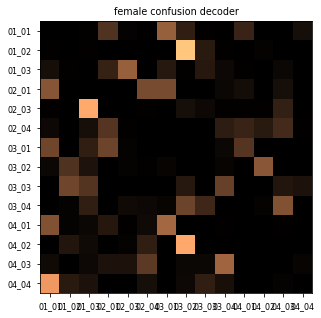

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
cm = confusion_matrix(np.concatenate(out['y_true']),np.concatenate(out['y_pred']))
plot_cm = (cm-np.min(cm))/(np.max(cm)-np.min(cm)) # normalize all to 0-1 scale
im = plt.imshow(plot_cm, cmap='copper', vmin=0, vmax=1)
ax_labels = np.unique(np.concatenate(out['y_true']))
plt.xticks(range(len(ax_labels)), ax_labels)
plt.yticks(range(len(ax_labels)), ax_labels)
plt.title('female confusion decoder')
fig.savefig(data_loc +'female_confusion_decoder_normalized.pdf', bbox_inches='tight')

## size distance

In [55]:
female_scalars = cal_scalars_sessions(female_mean_df,female_scalar_df,'robust')
scalars = ['height','width','area','length']

In [56]:
## correlate with euclidian distance of all metrics females
# pick mice that have at least 3 phases and 10 repetitions each (to match decoder)
minp = 3
minr= 10
phase_counts = female_mean_df.groupby('mouse')['group'].nunique()
rep_counts = female_mean_df.groupby('mouse')['rep'].nunique()
keep_mice = list(set(phase_counts[phase_counts >= minp].index) & set(rep_counts[rep_counts >= minr].index))

from sklearn.preprocessing import StandardScaler
# scale the scalars data
scale= StandardScaler()
df = female_scalars[['mouse','height','width','area','length']]
df = df[df['mouse'].isin(keep_mice)].groupby(by = ['mouse']).mean().reset_index()
data = df.drop(['mouse'], axis=1).to_numpy()
scaled_data = scale.fit_transform(data) 
mouse = df.mouse.to_numpy()
female_scaled = pd.DataFrame(np.vstack([mouse,scaled_data.T]).T, columns = list(df.columns))

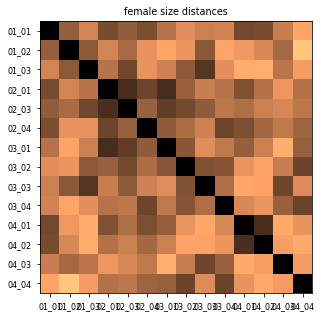

In [57]:
# get euclidean distance between a vector all scalars
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
curr = female_scaled.drop('mouse',axis=1).to_numpy() 
dist=np.zeros((len(curr),len(curr)),dtype=float)
for i in range(len(curr)):
    for j in range(len(curr)):
        dist[i][j] = np.linalg.norm(curr[i]-curr[j])

## plot
plot_dist = (dist-np.min(dist))/(np.max(dist)-np.min(dist))
im = plt.imshow(plot_dist, cmap='copper',vmin=0, vmax=1)
plt.xticks(range(len(ax_labels)), ax_labels)
plt.yticks(range(len(ax_labels)), ax_labels)
plt.title('female size distances')
fig.savefig(data_loc +'female_size_matrix_normalized.pdf', bbox_inches='tight')

## plot all against all

coefficient of determination: 0.01718922218112362
coefficient of determination: 0.0


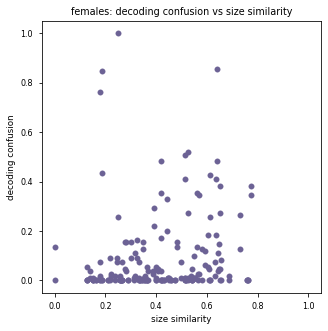

In [58]:
noz_cm = (plot_cm[~np.eye(plot_cm.shape[0],dtype=bool)].reshape(plot_cm.shape[0],-1)).flatten()
noz_dist = (plot_dist[~np.eye(plot_dist.shape[0],dtype=bool)].reshape(plot_dist.shape[0],-1)).flatten()

x = np.array(1-noz_dist).reshape(-1, 1)
y= noz_cm
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x,y)
r_sq = model.score(x,y)
print(f"coefficient of determination: {r_sq}")

lr = ElasticNet(alpha=0.01)
lr.fit(x, y)
r_sq=lr.score(x, y)
print(f"coefficient of determination: {r_sq}")

fig, ax = plt.subplots()
fig.set_size_inches(5,5)
plt.scatter(x,y,c='#6C6295')
ax.set_ylim(-0.05,1.05)
ax.set_xlim(-0.05,1.05)
ax.set_ylabel('decoding confusion')
ax.set_xlabel('size similarity')
ax.set_title('females: decoding confusion vs size similarity')
fig.savefig(data_loc +'female_size_vs_confusion_decoder.pdf', bbox_inches='tight')

# Male data

## identity decoder with leave one mouse out

In [59]:
#### upload data
decoder = 'mouse_confusion_decoder_male'
with open(data_loc+decoder+'.dat', 'rb') as f:
    out = pickle.load(f)

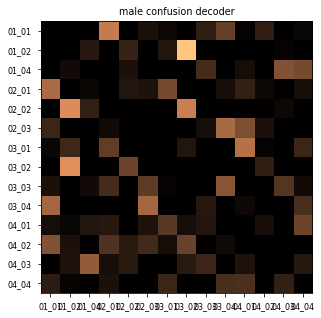

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
cm = confusion_matrix(np.concatenate(out['y_true']),np.concatenate(out['y_pred']))
plot_cm = (cm-np.min(cm))/(np.max(cm)-np.min(cm)) # normalize all to 0-1 scale
im = plt.imshow(plot_cm, cmap='copper', vmin=0, vmax=1)
ax_labels = np.unique(np.concatenate(out['y_true']))
plt.xticks(range(len(ax_labels)), ax_labels)
plt.yticks(range(len(ax_labels)), ax_labels)
plt.title('male confusion decoder')
fig.savefig(data_loc +'male_confusion_decoder_normalized.pdf', bbox_inches='tight')

## size distance

In [61]:
male_scalars = cal_scalars_sessions(male_mean_df,male_scalar_df,'robust')
scalars = ['height','width','area','length']

In [62]:
## correlate with euclidian distance of all metrics males
minr= 10
rep_counts = male_mean_df.groupby('mouse')['rep'].nunique()
keep_mice = list(rep_counts[rep_counts >= minr].index) # keep mice that have at least 10 sessions

from sklearn.preprocessing import StandardScaler
# scale the scalars data
scale= StandardScaler()
df = male_scalars[['mouse','height','width','area','length']]
df = df[df['mouse'].isin(keep_mice)].groupby(by = ['mouse']).mean().reset_index()
data = df.drop(['mouse'], axis=1).to_numpy()
scaled_data = scale.fit_transform(data) 
mouse = df.mouse.to_numpy()
male_scaled = pd.DataFrame(np.vstack([mouse,scaled_data.T]).T, columns = list(df.columns))

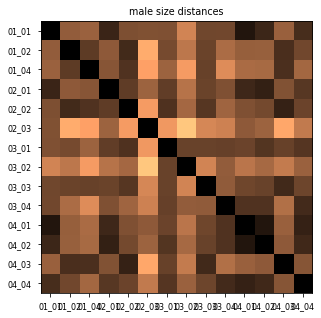

In [63]:
# get euclidean distance between a vector all scalars
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
curr = male_scaled.drop('mouse',axis=1).to_numpy() 
dist=np.zeros((len(curr),len(curr)),dtype=float)
for i in range(len(curr)):
    for j in range(len(curr)):
        dist[i][j] = np.linalg.norm(curr[i]-curr[j])

## plot
plot_dist = (dist-np.min(dist))/(np.max(dist)-np.min(dist))
im = plt.imshow(plot_dist, cmap='copper',vmin=0, vmax=1)
plt.xticks(range(len(ax_labels)), ax_labels)
plt.yticks(range(len(ax_labels)), ax_labels)
plt.title('male size distances')
fig.savefig(data_loc +'male_size_matrix_normalized.pdf', bbox_inches='tight')

## plot all against all

coefficient of determination: 0.02957926561846913
coefficient of determination: 0.0030687656875111324


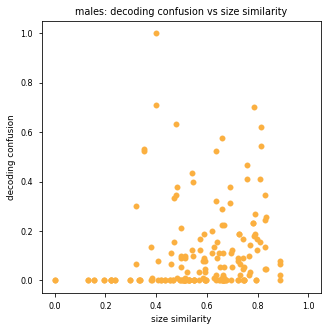

In [64]:
noz_cm = (plot_cm[~np.eye(plot_cm.shape[0],dtype=bool)].reshape(plot_cm.shape[0],-1)).flatten()
noz_dist = (plot_dist[~np.eye(plot_dist.shape[0],dtype=bool)].reshape(plot_dist.shape[0],-1)).flatten()

x = np.array(1-noz_dist).reshape(-1, 1)
y= noz_cm
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x,y)
r_sq = model.score(x,y)
print(f"coefficient of determination: {r_sq}")

lr = ElasticNet(alpha=0.01)
lr.fit(x, y)
r_sq=lr.score(x, y)
print(f"coefficient of determination: {r_sq}")

fig, ax = plt.subplots()
fig.set_size_inches(5,5)
plt.scatter(x,y,c='#FBB040')
ax.set_ylim(-0.05,1.05)
ax.set_xlim(-0.05,1.05)
ax.set_ylabel('decoding confusion')
ax.set_xlabel('size similarity')
ax.set_title('males: decoding confusion vs size similarity')
fig.savefig(data_loc +'male_size_vs_confusion_decoder.pdf', bbox_inches='tight')